In [1]:
import sys
import pandas as pd
import itertools

path:str = '/Users/juanbeta/My Drive/Research/Energy/E-CVRP-TW/Code/'
#path: str = 'C:/Users/jm.betancourt/Documents/Research/Energy//E-CVRP-TW/Code/'

from E_CVRP_TW import  E_CVRP_TW, Feasibility
env = E_CVRP_TW(path)

sys.path.insert(0,path+'Experimentation/')
import plot_performance as plot

# Constructive

### Restrictive criterion

Testing various restriction configuration for the RCL

In [2]:
criterions = ['distance', 'TimeWindow','Intra-Hybrid', 'Exo-Hybrid']
data_crit = dict()
for instance in env.instances:
    data_crit[instance] = dict()
    for criterion in criterions:
        data = plot.retrieve_const_performance(instance, path+f'Experimentation/Constructive/RCL criterion/{criterion}/')
        data_crit[instance][criterion] = dict() 
        data_crit[instance][criterion]['min_dist'] = data[0]
        data_crit[instance][criterion]['min_EV'] = data[1]

In [3]:
print(' \t \t \tDist \t \t \t \t \tTW \t \t \t \t \tIntra-H \t \t \t \t \tExo-H')
print('Instance \tM \tEV \tFO \tgap \ts \t \tEV \tFO \tgap \ts \t \tEV \tFO \tgap \ts \t \tEV \tFO \tgap \ts')

objective = 'min_EV'

for instance in env.sizes['l'][:10]:
    env.load_data(instance)
    things = [instance, len(env.Costumers)]
    for criterion in criterions:
        things += [len(data_crit[instance][criterion][objective]['best individual']),
                    round(data_crit[instance][criterion][objective]['best distance'],2),
                    data_crit[instance][criterion][objective]['gap'],
                    round(data_crit[instance][criterion][objective]['time to find'],2),
                    ' ']
    print(*things,sep = '\t')

 	 	 	Dist 	 	 	 	 	TW 	 	 	 	 	Intra-H 	 	 	 	 	Exo-H
Instance 	M 	EV 	FO 	gap 	s 	 	EV 	FO 	gap 	s 	 	EV 	FO 	gap 	s 	 	EV 	FO 	gap 	s
c101_21.txt	100	23	2142.96	103.35	161.53	 	16	1973.05	87.23	281.38	 	18	1950.15	85.05	158.83	 	18	2049.47	94.48	158.61	 
c102_21.txt	100	21	2225.03	110.61	237.45	 	17	1906.2	80.43	462.31	 	18	1849.59	75.07	225.19	 	18	1847.18	74.84	193.61	 
c103_21.txt	100	19	1976.02	97.2	143.97	 	17	1908.36	90.45	123.28	 	17	1844.65	84.09	217.78	 	17	1673.85	67.05	114.41	 
c104_21.txt	100	14	1480.89	51.19	58.48	 	15	1884.95	92.44	379.41	 	14	1730.88	76.71	80.77	 	14	1555.24	58.78	239.91	 
c105_21.txt	100	20	2161.2	100.97	336.03	 	15	1906.38	77.28	228.06	 	17	2002.11	86.18	19.88	 	17	1915.85	78.16	447.3	 
c106_21.txt	100	19	1946.19	83.95	121.33	 	16	1931.92	82.61	291.56	 	17	1965.65	85.79	209.62	 	17	1908.14	80.36	335.41	 
c107_21.txt	100	19	2033.61	97.14	404.11	 	15	1796.44	74.15	59.58	 	17	1943.2	88.37	146.48	 	16	2102.48	103.82	425.78	 
c108_21.txt	100	17	1829.82	8

In [4]:
instance = env.sizes['l'][4]
criterion = 'TimeWindow'
objective = 'min_EV'

print(f'########## Performance ##########')
print(f'incumbent: {round(data_crit[instance][criterion][objective]["best distance"],2)}')
print(f'gap: {round((data_crit[instance][criterion][objective]["best distance"] - env.bkFO[instance])/env.bkFO[instance]*100,2)}%')
print(f'time to find: {round(data_crit[instance][criterion][objective]["time to find"],2)}')

########## Performance ##########
incumbent: 1906.38
gap: 77.28%
time to find: 228.06


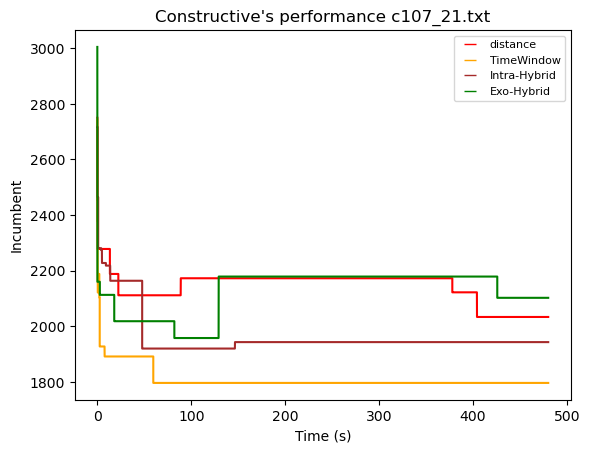

In [5]:
instance = env.sizes['l'][6]
plot.plot_const_performance(data_crit[instance],instance, objective = 'min_EV')

In [6]:
##### Export data to Excel
data = data_crit 

d = {'instance': [], 'M':[]}
for instance in env.instances:
    env.load_data(instance)
    d['instance'].append(instance)
    d['M'].append(len(env.Costumers))

for criterion in criterions:
    d[f'{criterion}/# EV'] = [len(data[instance][criterion]['min_EV']['best individual']) for instance in env.instances]
    d[f'{criterion}/FO'] = [round(data[instance][criterion]['min_EV']['best distance'],2) for instance in env.instances]
    # d[f'{criterion}/gap'] = [data[instance][criterion]['gap'] for instance in env.instances]
    d[f'{criterion}/t'] = [round(data[instance][criterion]['min_EV']['time to find'],2) for instance in env.instances]

df = pd.DataFrame(data = d)
df.to_excel('criterions.xlsx')

# Operators

## Darwinian phi rate

In [7]:
operator = 'Darwinian phi rate'
# Configurations = {'Darwinian phi rate':{'penalization':['regular','cuadratic','cubic'],
#                                         'conservation proportion':[0.2, 0.4, 0.7],
#                                         'length restriction':[True, False],
#                                         }}

Configurations = {'Darwinian phi rate':{'penalization':['cuadratic','cubic'],
                                        'conservation proportion':[0.4, 0.7],
                                        'length restriction':[True, False],
                                        }}

keys = list(Configurations[operator].keys())
combinations = list(itertools.product(*[Configurations[operator][key] for key in keys]))
Grid = [{operator: {keys[i]: combination[i] for i in range(len(keys))}} for combination in combinations]

data_Darwin = dict()

for instance in env.instances:
    data_Darwin[instance] = dict()
    for ii in Grid:
        config = ii[operator]
        identifier = str()
        for a in Configurations[operator].keys():
            identifier += str(config[a])+str('_')
        identifier = identifier[:-1]
        data_Darwin[instance][identifier] = plot.retrieve_op_performance(instance, path+f'Experimentation/Operators/{operator}/results-{identifier}-{instance}')

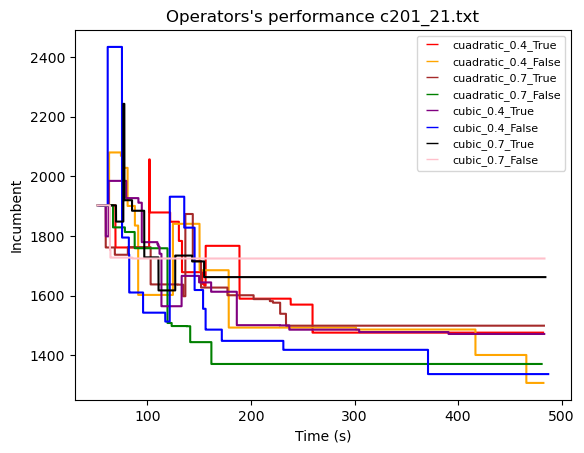

In [8]:
instance = env.sizes['l'][9]
plot.plot_op_performance(data_Darwin[instance],instance, objective = 'min_EV')

## evaluated insertion

In [29]:
operator = 'evaluated insertion'
Configurations = {'evaluated insertion':{'penalization':['regular','cuadratic','cubic'],
                                         'criterion':['random']}}
                                        #  'criterion':['Hybrid', 'phi rate', 'visited costumers']}}#, 'random']}}

keys = list(Configurations[operator].keys())
combinations = list(itertools.product(*[Configurations[operator][key] for key in keys]))
Grid = [{operator: {keys[i]: combination[i] for i in range(len(keys))}} for combination in combinations]

data_insert = dict()

for instance in env.instances:
    data_insert[instance] = dict()
    for ii in Grid:
        config = ii[operator]
        identifier = str()
        for a in Configurations[operator].keys():
            identifier += str(config[a])+str('_')
        identifier = identifier[:-1]
        data_insert[instance][identifier] = plot.retrieve_op_performance(instance, path+f'Experimentation/Operators/{operator}/results-{identifier}-{instance}')

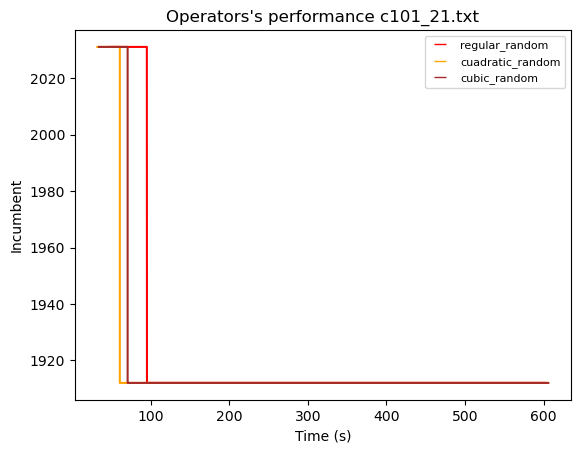

In [30]:
instance = env.sizes['l'][0]
plot.plot_op_performance(data_insert[instance],instance, objective = 'min_EV')

In [ ]:
##### Export data to Excel
list_idx = 2

d = {'instance': [], 'M':[]}#, 'const/#EV':[], 'const/FO':[], 'const/t':[]}
for instance in env.instances:
    env.load_data(instance)
    d['instance'].append(instance)
    d['M'].append(len(env.Costumers))

for ii in Grid:
    config = ii[operator]
    identifier = str()
    for a in Configurations[operator].keys():
        identifier += str(config[a])+str('_')
    identifier = identifier[:-1]
    d[f'{identifier}/# EV'] = [len(data_insert[instance][identifier][list_idx]['best individual']) for instance in env.instances]
    d[f'{identifier}/FO'] = [round(data_insert[instance][identifier][list_idx]['best distance'],2) for instance in env.instances]
    # d[f'{criterion}/gap'] = [data[instance][criterion]['gap'] for instance in env.instances]
    d[f'{identifier}/t'] = [round(data_insert[instance][identifier][list_idx]['time to find'],2) for instance in env.instances]


df = pd.DataFrame(data = d)
df.to_excel('oppp-results.xlsx')